# Solving ODEs

This Notebook is focused on the mechanics of solving ordinary differential equations (ODEs) using numerical methods. We use numerical methods to solve differential equations in cases where analytical solutions are either impossible or too tedious to warrant the effort. First, we will work through some examples that demonstrate how the most common numerical ODE solvers work (in general terms), and then we will cover the numerical solution of ordinary differential equations using packages that are available in `scipy`. Keep in mind that we have already covered a set of numerical methods for solving ***algebraic equations*** in [Notebook 03](https://jqbond.github.io/CEN587/Notebooks/587-N03.html). In this Notebook, we will develop skills with a complementary set of tools for solving ***differential equations***.

## Topics Covered

1. Scipy package; `scipy.integrate`; `scipy.interpolate` 
2. Solution of initial value problems for a single ODE using numerical ODE solvers with `scipy.integrate.solve_ivp()`.
3. Solution of coupled systems of ODEs using numerical ODE solvers `scipy.integrate.solve_ivp()`.
4. Solution of definite integrals using `scipy.integrate.quad`
5. Interpolation (1D) using `scipy.interpolate.interp1d()`
6. Combining numerical methods, e.g., `scipy.optimize.newton()` and `scipy.integrate.quad()` or `scipy.integrate.solve_ivp()`

In [113]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt
from scipy.integrate import solve_ivp, quad
from scipy.interpolate import interp1d

## Problem 1

The following differential equation describes how the variable $x$ changes as a function of time:

$$\frac{dx}{dt} = k\left(1 - x\right)^2$$

The initial value of $x$ is zero, i.e., $x(0) = 0$.

For this system, $k = 0.253 \ \mathrm{min}^{-1}$. Calculate the value of $x$ after 10 minutes, i.e., $x(10)$.

### Solution to Problem 01

This is an Ordinary Differential Equation written in terms of a single state variable, $x$, a single independent variable, $t$, and a constant, $k$. This is an example of what we call and "initial value problem" in that we know the value of our state dependent variable at the initial time $(t = 0 \ \mathrm{minutes})$, and we are asked about its value at some time in the future $(t = 10 \ \mathrm{minutes})$. This is also an example of a separable differential equation, and it can be solved analytically to find $x(t)$. Specifically, if we separate variables:

$$\frac{1}{(1-x)^2}dx = kdt$$

We can integrate from lower limits to upper limits:

$$\int_0^x\frac{1}{(1-x^\prime)^2}dx^\prime = \int_0^tkdt^\prime$$

We can solve this using a substitution method to find $x$ as a function of $t$:

$$x(t) = 1 - \frac{1}{1+kt}$$

We won't use it yet, but note we can also solve this to get $t$ as a function of $x$:

$$t(x) = \frac{1}{k}\left(\frac{1}{1 - x} - 1\right)$$

```{note}
We will use this differential equation as a test case to demonstrate the numerical solution of ODEs both conceptually and using Python. When we are learning a new skill set like an approach to solving a certain type of problem, it is useful to use the new method to solve problems that we already know the answer to. This improves our confidence with the new strategy and helps us to be certain that we know how to apply the method correctly before we move on to new problems that we do not already know the answer to.
```

In [114]:
##############################################################
# This is the Analytical Solution to our ODE                 #
##############################################################

k  = 0.253
dx = lambda x: k*(1-x)**2
x  = lambda t: (1 - 1/(1 + k*t))
dx(0)
x(10)
print(f'at t = 10 minutes, x = {x(10):10.8f}')

at t = 10 minutes, x = 0.71671388


### Graphing the analytical solution

If we have an analytical solution for $x(t)$, it's always nice to plot it so we can visualize how it behaves. We will do this on the domain $t = [0, 10]$; the final value in this time range, $x(10)$, is the solution to the initial value problem posed above.

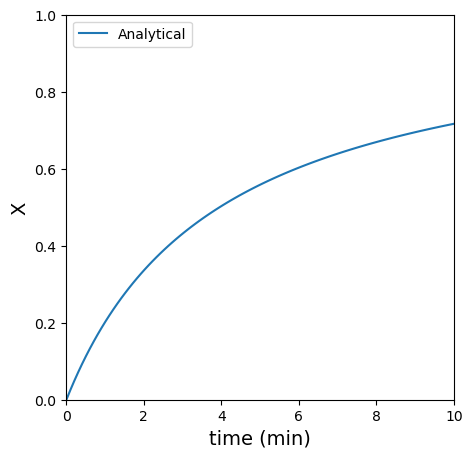

In [115]:
########################################################################## 
# This cell graphs the analytical solution for x(t) from t = 0 to t = 10 #
##########################################################################

tplot = np.linspace(0,10,100)
xplot = x(tplot)
plt.figure(figsize = (5, 5))
plt.plot(tplot, xplot, label = 'Analytical')
plt.xlabel('time (min)', fontsize = 14)
plt.ylabel('X', fontsize = 14)
plt.xlim(0,10)
plt.ylim(0,1)
plt.legend(loc = 'upper left')
plt.show()

### Numerical solution to Problem 01

Now we'll pretent that we don't actually know the analytical solution to the above differential equation. In this case, we will need to obtain an approximate solution using a numerical method. We will find ourselves in this position any time the ODE is non-separable or cannot otherwise be put into a standard form for which solutions are already known. 

```{tip}
Most problems in the reactor design will need to be solved numerically, especially realistic reactor design problems that are relevant to industrial practice.
``` 

#### The Euler Method

As a first attempt, we'll use a numerical method called an "Euler's Method" or an "Euler Step." The algorithm we use in this case is not particularly sophisticated -- we will use a forward difference approximation for the derivative. That said, the method uses an iterative, step-based strategy for solving differential equations. As we transition to more sophisticated methods, like a Runge Kutta algorithm, we will notice that they use different and better algorithms for estimating the derivatives of state variables, but at their core, they still use iterative steps to solve a differential equation. Thus, the step-based straegy employed in an Euler Method is general and extensible.

The basic idea behind all step-based ODE solvers is that we will use information about the derivative of a function at the current "time" (independent variable) to estimate where the function will be at some point in the future (a future time or a future position). This is based on the concept that the derivative of a function tells us the change in dependent variable that occurs when we change the dependent variable, i.e., for this function:

$$\frac{dx}{dt} = m$$

Where $m$ is the slope of the function $x(t)$ at a given point in time.  We don't know what the function is, but we do know what its derivative (slope) is:

$$\frac{dx}{dt} = k\left(1 - x\right)^2$$

We can **approximate** a derivative using discrete (i.e., non-differential) changes in $x$ and $t$, similar to what we did when we first learned about a slope as "rise over run".

$$\frac{dx}{dt} \approx \frac{\Delta x}{\Delta t}$$

We can discretize that to describe the change in $x$ and $t$ in terms of their current state (position $i$) and their state at one step in the future (position $i+1$). 

$$\left(\frac{dx}{dt}\right)_i \approx \frac{(x_{i+1} - x_i)}{(t_{i+1} - t_i)}$$

```{note}
The technical term for this particular approximation is a ***forward difference*** method of approximating a derivative. We call it this because it uses information from the current state, $i$, and a future state, $i+1$ to estimate the derivative at the current state, $i$.  There are also ***backward difference*** and ***central difference*** methods that we might use depending on the situation.
```

Extending that idea, if we know the derivative (slope), we can make a small step in the independent variable ($\Delta t = t_{i+1} - t_i$) and estimate where the dependent variable ends up after we make the step:

$$x_{i+1} \approx x_i + \left(\frac{dx}{dt}\right)_i(t_{i+1} - t_i)$$

Usually, when we are using step based ODE solvers, either we or the algorithm will specify the size of steps taken in the independent variable and then estimate the response in the dependent variable. For consistency with the Runge-Kutta notation below, we will call the time step $\Delta t = h$, giving the following equation for an Euler method, where $h$ is the size of the "step" in the independent variable:

$$x_{i+1} \approx x_i + \left(\frac{dx}{dt}\right)_i h$$

Finally, in this specific example, we know that $\frac{dx}{dt} = k(1-x)^2$, so:

$$x_{i+1} \approx x_i + k(1-x_i)^2 h$$

We now have all of the information necessary to write an iterative loop to solve this using a numerical method. Remember: this is not an analytical solution, and it will only give us an approximation of the behavior of $x(t)$ in set of discrete points (not as a function). This algorithm is implemented using a for loop below. We do this by by specifying the number of steps that the solver will take to reach the final time of interest (10 minutes). We can change the number of steps taken as needed, and the script will auotomatically adjust the step size in response to the number of steps we want to make so that it always ends at $t = 10 \ \mathrm{minutes}$. One should consider that as we take more steps between 0 and 10 minutes, the size of each time step must get smaller. 

We'll start by attempting to find the value of $x$ at $t = 10$ by taking 5 steps to reach $t = 10 \ \mathrm{minutes}$ using an Euler method. We will start the iteration at the start of our initial value problem, i.e., at $t = 0$, $x = 0$...and we'll step forward in time until we reach $t = 10$.  We'll plot the result to see how well it compares with the true solution.

At t = 10 minutes with 5 steps and a step size of 2.00:
 the Euler method predicts that x = 0.77775999, and the true value is 0.71671388


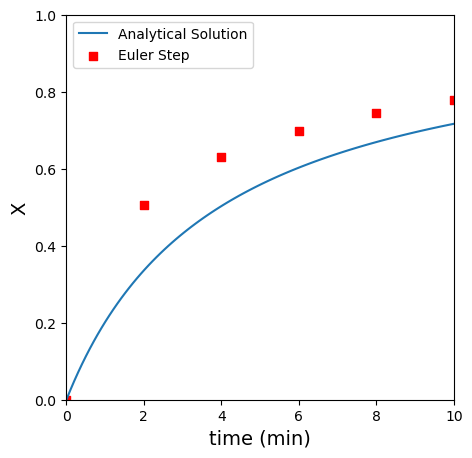

In [116]:
###########################################################################################################
# This cell encodes a for loop to solve the ODE using Euler's Method                                      #
###########################################################################################################

nsteps = 5
tmax   = 10
h      = tmax/nsteps
tEU    = np.zeros(nsteps+1) #I'm creating the numpy array where I'll store all values of time.
xEU    = np.zeros(nsteps+1) #Likewise, I want to store all values of x for plotting.

###########################################################################################################
# This for loop iteratively solves the Euler Method algorithm until we reach t = 10 minutes               #
###########################################################################################################

for i in range(0, nsteps):
    xEU[i+1] = xEU[i] + h*dx(xEU[i])
    tEU[i+1] = tEU[i] + h

###########################################################################################################
# This block overlays the analytical solution and the Euler Method solution                               #
###########################################################################################################

print(f'At t = {tmax} minutes with {nsteps} steps and a step size of {h:4.2f}:\n the Euler method predicts that x = {xEU[-1]:10.8f}, and the true value is {x(tmax):10.8f}')    
plt.figure(1, figsize = (5, 5))
plt.plot(tplot, xplot, label = 'Analytical Solution')
plt.scatter(tEU, xEU, color = 'red', marker = 's', label = 'Euler Step')
plt.xlabel('time (min)', fontsize = 14)
plt.ylabel('X', fontsize = 14)
plt.xlim(0,10)
plt.ylim(0,1)
plt.legend(loc = 'upper left')
plt.show()

#### Problems with the Euler Method

You can see that an Euler method does a pretty bad job here. This is because we are making large steps and assuming that the derivative value doesn't change over the span of that step, which clearly isn't true when you consider that $\frac{dx}{dt} = k(1-x)^2$: ***as $x$ changes, the slope of the line also changes.*** So the forward difference method we used is a really rough approximation if we take large steps in $t$ (which result in large changes in $x$). We won't see good agreement between the analytical solution and Euler's Method unless we take a lot of steps (see below). Try to progressively adjust the step size to get a feel for how many steps (and how small each step needs to be) to get reasonable accuracy with an Euler method.

At t = 10 minutes with 50 steps and a step size of 0.20:
 the Euler method predicts that x = 0.72189170, and the true value is 0.71671388


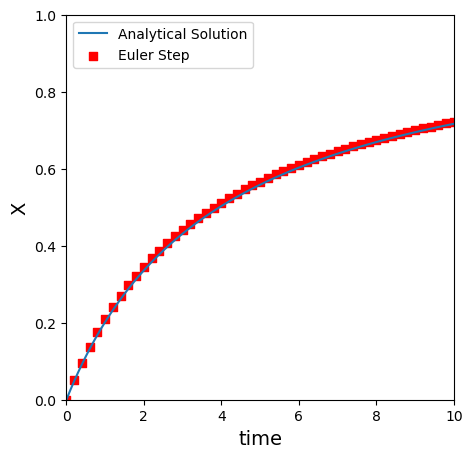

In [117]:
###########################################################################################################
# This cell encodes a for loop to solve the ODE using Euler's Method                                      #
###########################################################################################################

nsteps = 50 #Adjust the number of steps taken by the solver here!
tmax   = 10
h      = tmax/nsteps
tEU    = np.zeros(nsteps+1) #I'm creating the numpy array where I'll store all values of time.
xEU    = np.zeros(nsteps+1) #Likewise, I want to store all values of x for plotting.

###########################################################################################################
# This for loop iteratively solves the Euler Method algorithm until we reach t = 10 minutes               #
###########################################################################################################

for i in range(0, nsteps):
    xEU[i+1] = xEU[i] + h*dx(xEU[i])
    tEU[i+1] = tEU[i] + h

###########################################################################################################
# This block overlays the analytical solution and the Euler Method solution                               #
###########################################################################################################

print(f'At t = {tmax} minutes with {nsteps} steps and a step size of {h:4.2f}:\n the Euler method predicts that x = {xEU[-1]:10.8f}, and the true value is {x(tmax):10.8f}')    
plt.figure(1, figsize = (5, 5))
plt.plot(tplot, xplot, label = 'Analytical Solution')
plt.scatter(tEU, xEU, color = 'red', marker = 's', label = 'Euler Step')
plt.xlabel('time', fontsize = 14)
plt.ylabel('X', fontsize = 14)
plt.xlim(0,10)
plt.ylim(0,1)
plt.legend(loc = 'upper left')
plt.show()

### Higher Order Methods for solving ODEs

There are far more accurate methods for numerical integration.  Many, many methods, actually.  We'll usually be able to use the classic 4th order Runge Kutta method in this class.  Occasionally, we may run into a stiff ODE system that will require us to use a stiff solver, but we'll cross that bridge when we come to it. An explict 4th order Runge Kutta method is a fancy adaptation of the Euler method that is able to better anticipate how the derivative of the function will change across the span of the step. This makes it much, much more accurate, and we'll find that we can get almost analytical precision with only a few steps. It looks much more complicated, but the basic principle is the same. If you inspect the RK equations carefully, you'll see that we are still using the current (known) value of the function and the current (known) derivative of the function to estimate where the function will be at some point in the future. If you want to read a more about 4th order Runge-Kutta methods, it's worth a quick look at least at Wikipedia, though you can get probably get more thorough discussion in a numerical methods book.

https://en.wikipedia.org/wiki/Runge-Kutta_methods

If you skim that page, you'll see the equations used to develop the iteration scheme for the RK method in the cell below.

At t = 10 minutes with 5 steps and a step size of 2.00:
 the RK method predits that x = 0.71669966, and the true value is 0.71671388


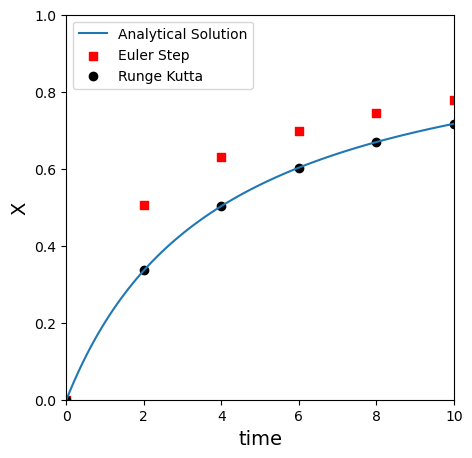

In [118]:
###########################################################################################################
# This cell includes for loops to solve the ODE using Euler and Runge-Kutta methods                       #
###########################################################################################################

nsteps = 5
tmax   = 10
h      = tmax/nsteps
xRK    = np.zeros(nsteps+1) #RK x values
tRK    = np.zeros(nsteps+1) #RK t values
tEU    = np.zeros(nsteps+1) #Euler x values
xEU    = np.zeros(nsteps+1) #Euler t values

###########################################
# For loop to solve using an Euler Method #
###########################################

for i in range(0, nsteps):
    xEU[i+1] = xEU[i] + h*dx(xEU[i])
    tEU[i+1] = tEU[i] + h


################################################
# For loop to solve using a Runge-Kutta Method #
################################################

for i in range(0, nsteps):
    dxdt  = dx(xRK[i]) #compute derivative, dx/dt @ x[i], t[i]
    k1    = dxdt       #RK parameter "k1[i]" is equal to derivative "dxdt[i] 
    k2    = dx(xRK[i] + h/2*k1) #RK parameter "k2[i]" is a function of x and dxdt
    k3    = dx(xRK[i] + h/2*k2) #RK parameter "k3[i]" is a function of x and dxdt
    k4    = dx(xRK[i] + h*k3)   #RK parameter "k4[i]" is a function of x and dxdt

    xRK[i+1] = xRK[i] + 1/6*h*(k1 + 2*k2 + 2*k3 + k4) #value of x after step is taken
    tRK[i+1] = tRK[i] + h #step time forward by h


################################################
# Overaly analytical, Euler, and RK solutions  #
################################################

print(f'At t = {tmax} minutes with {nsteps} steps and a step size of {h:4.2f}:\n the RK method predits that x = {xRK[-1]:10.8f}, and the true value is {x(tmax):10.8f}')    
plt.figure(1, figsize = (5, 5))
plt.plot(tplot, xplot, label = 'Analytical Solution')
plt.scatter(tEU, xEU, color = 'red', marker = 's', label = 'Euler Step')
plt.scatter(tRK, xRK, label = 'Runge Kutta', marker = 'o', color = 'black')
plt.xlabel('time', fontsize = 14)
plt.ylabel('X', fontsize = 14)
plt.xlim(0,10)
plt.ylim(0,1)
plt.legend(loc = 'upper left')
plt.show()

### ODE Solvers in Python

Writing numerical methods from scratch (as done above) is good from an educational standpoint, but, in most cases at the present time, it is cumbersome and inefficient to write your own ODE solvers. Generally, better tools are available in Python's `scipy.integrate` package. They will typically use a 4th order Runge Kutta method as their default algorithm, but they also give us access to many additional options and solvers beyond Runge-Kutta, and they avoid the overhead of actually needing to write loops and make decisions about appropriate step sizes. Usually, the algorithm will do a far better job of deciding on the step size than we will.  

For an example of solving ODEs/IVPs using Python, see the script below. This accomplishes a similar result to our own RK loop using only a few lines of code. In Python/Scipy, we solve initival value problems using a function called `solve_ivp()` that is defined in `scipy.integrate`. The main thing to keep in mind when using `solve_ivp()` is that, similar to `opt.root()` or `opt.newton()`, it will operate on a function that we define. `solve_ivp()` mandates that this function adheres to a few particular formatting and syntax conventions. By default, the function that we create needs to:

1. Be of the form $f(\mathrm{independent \ variable, \ dependent \ variable(s)})$, e.g., $f(t, x)$
2. Have only one independent variable (e.g., $t$). 
3. Structure the dependent variables as single array argument. This single array argument can have many individual elements that correspond to each state variable in our system. 
4. Return the derivative of each state dependent variable at the current state of the system.

In [119]:
####################################################################################################################
# This is an example of a properly formatted function for use with solve_ivp()                                     #
# This is the way we would write our example ODE, dx/dt = k*(1-x)^2, such that it can be solved using solve_ivp()  #
####################################################################################################################

def DX(t, x):
    der = k*(1-x)**2
    return der

In [120]:
####################################################################################################################
# This cell uses solve_ivp to implement a step-based algorithm to solve the differential equation                  #
# It does this by integrating from our prescribed time span from t = 0 to t = 10.                                  #
####################################################################################################################

tspan = (0.0, 10.0)
x0    = [0.0]
ans = solve_ivp(DX, tspan, x0)
ans

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  1.000e-04  1.100e-03  1.110e-02  1.111e-01
             1.111e+00  2.978e+00  5.845e+00  1.000e+01]
        y: [[ 0.000e+00  2.530e-05  2.782e-04  2.800e-03  2.734e-02
              2.194e-01  4.296e-01  5.963e-01  7.165e-01]]
      sol: None
 t_events: None
 y_events: None
     nfev: 50
     njev: 0
      nlu: 0

Notice that this is actually pretty similar to the way we use `opt.root()`.  The particulars about how we format the function are a little different, but there are many common features, one of which is that `solve_ivp()` returns a solution structure with a lot of information in it. The information is typically stored as "fields" or "attributes" within the solution structure. The basic syntax for accessing fields is `structure_name.field_name`. The biggest things we'll want to check is whether the solution converged (`.success` or `.message`); the values of the independent variable (`.t` field); and the values of the dependent variable (`.y` field). We should take a look at the dimensions of the `.t` and `.y` fields.  This can cause some quirks when we try to use them.

```{tip}
Numerical methods in Python typically return solutions in structures. They are information-rich, but it is not obvious at first how to extract information from them. ODE solutions will have a lot more information than just the "answer" to the initial value problem. Usually, they will store values of the state and independent variables as discrete series that are stored in `numpy` arrays. It will be important for us to understand the dimensions of those arrays as we attempt to use solution structures returned by ODE solvers
```

In [121]:
############################################################################################### 
# Printing various elements of the solution structure and characteristics of .t and .y fields #
###############################################################################################

print(ans)         #Display the full solution structure
print(ans.message) #Display the message field from the solution structure
print(ans.success) #Display the success field from the solution structure (did the solver succeed?)
print(ans.t)       #Display the values of the independent variable that the solver stepped to
print(ans.y)       #Display the array of all state variables at each value of the independent variable that the solver stepped to
print(ans.t.shape) #Display the shape of the array containing all values of the independent variable 
print(ans.y.shape) #Display the shape of the array containing all values of all state dependent variables
print(ans.t.ndim)  #Display the number of dimensions of the array containing all values of the independent variable
print(ans.y.ndim)  #Display the number of dimensions of the array containing all values of all dependent variables

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  1.000e-04  1.100e-03  1.110e-02  1.111e-01
             1.111e+00  2.978e+00  5.845e+00  1.000e+01]
        y: [[ 0.000e+00  2.530e-05  2.782e-04  2.800e-03  2.734e-02
              2.194e-01  4.296e-01  5.963e-01  7.165e-01]]
      sol: None
 t_events: None
 y_events: None
     nfev: 50
     njev: 0
      nlu: 0
The solver successfully reached the end of the integration interval.
True
[0.00000000e+00 1.00000000e-04 1.10000000e-03 1.11000000e-02
 1.11100000e-01 1.11110000e+00 2.97828855e+00 5.84479777e+00
 1.00000000e+01]
[[0.00000000e+00 2.52993599e-05 2.78222571e-04 2.80043554e-03
  2.73398240e-02 2.19418001e-01 4.29606264e-01 5.96345844e-01
  7.16462085e-01]]
(9,)
(1, 9)
1
2


#### Extracting information from the solution structure

If we want to know the value of our dependent variable ($x$) at $t = 10$, well, we integrated this problem from $0$ to $10$, so the last value in our `sol.y` set is the one that we want.  We can extract it from that array and see that it agrees very closely with the analytical solution (notice issues with indexing due to 2D shape of `sol.y`).  In Python, there are multiple ways that we can do this; they are included in the cell below. Before proceeding, make sure all of the indexing makes sense to you based on what you know about Python and `numpy` arrays.

In [122]:
###############################################################################################
# Accessing the value of the state dependent variable at t = 10                               #
###############################################################################################

print(ans.y, '\n')
print(ans.y.size, '\n')
print(ans.y[0], '\n')
last_y_index = ans.y.size -1
print(last_y_index)
print(ans.y[0][last_y_index], '\n')
print(ans.y[0,last_y_index], '\n')
print(ans.y[0,-1], '\n')
print(f'At t = 10, solve_IVP gives x = {ans.y[0,-1]:10.8f}, and the analytical solution is x = {x(10.0):10.8f}')

[[0.00000000e+00 2.52993599e-05 2.78222571e-04 2.80043554e-03
  2.73398240e-02 2.19418001e-01 4.29606264e-01 5.96345844e-01
  7.16462085e-01]] 

9 

[0.00000000e+00 2.52993599e-05 2.78222571e-04 2.80043554e-03
 2.73398240e-02 2.19418001e-01 4.29606264e-01 5.96345844e-01
 7.16462085e-01] 

8
0.7164620845152828 

0.7164620845152828 

0.7164620845152828 

At t = 10, solve_IVP gives x = 0.71646208, and the analytical solution is x = 0.71671388


#### Graphing the solution from Python's ODE solver

Now that we have the problem solved, we can plot the data.  

Some things to notice--first, it is very accurate compared to an Euler method, with very little effort and using only default options.  Second, this solver does not take uniform steps, nor do we get control over the steps it takes by default.  In general, these algorithms use adaptive step sizes which makes them very efficient. We are usually going to want the solver to pick the time steps for us.

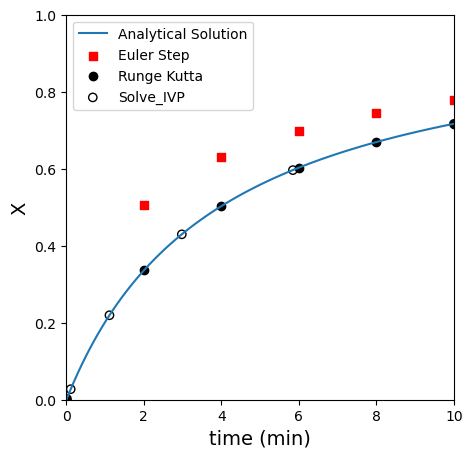

In [123]:
##########################################################################################
# Overlay the solve_ivp() solution with analytical, Euler Step, and homebrew RK method   #
##########################################################################################

tout = ans.t
xout = ans.y
plt.figure(1, figsize = (5, 5))
plt.plot(tplot, xplot, label = 'Analytical Solution')
plt.scatter(tEU, xEU, color = 'red', marker = 's', label = 'Euler Step')
plt.scatter(tRK, xRK, label = 'Runge Kutta', marker = 'o', color = 'black')
plt.scatter(tout, xout, c = 'None', edgecolor = 'black', label = "Solve_IVP")
plt.xlabel('time (min)', fontsize = 14)
plt.ylabel('X', fontsize = 14)
plt.xlim(0,10)
plt.ylim(0,1)
plt.legend(loc = 'upper left')
plt.show()

## A more common question in reactor design:

The above IVP problem is common in a mathematics or differential equations course. It is less common (though not unheard of) in a reactor design course.  The reason is that in the above problem, we already know the value of the independent variable (time) that is of interest to us (10 minutes), so there is no question about the integration span. We know that we'll integrate from $t = 0$ to $t = 10$, and we are only looking for the value of the state dependent variable, $x$, at that time. In reactor design, we often ask the opposite question of "how long will a process take to achieve 70% conversion?" or "how large does the reactor need to be to generate a product yield of 45%?" These are examples of questions where we know the value of the state dependent variable that we want to have at the end of the integration span, but we do not know a priori the end of the integration span as this is the answer to the question we're being asked. With numerical methods, it is much easier to deal with problems where we know the final value of the independent variable (integration span is known) than it is to deal with problems where we know the final value of the state dependent variable (integration span is unknown).  Below, we illustrate this type of problem using the same ODE that we solved above. Notice the slightly different question -- it is nuanced and subtle, but it makes a substantial difference in how we have to approach the solution with a numerical method.  We'll see how this plays out as we work through this problem in the cells below.

Given:

$$\frac{dx}{dt} = k\left(1 - x\right)^2$$

The initial value of $x$ is zero, i.e., $x(0) = 0$.

For this system, $k = 0.253 \ \mathrm{min}^{-1}$. How long will it take for $x$ to reach a value of $0.85$?

### Solution to the more common question in reactor design

In the first example, we solved analytically for $x(t)$; let's plot it over a large time span to see if we can figure out roughly where in time we would find a value of $x = 0.85$.

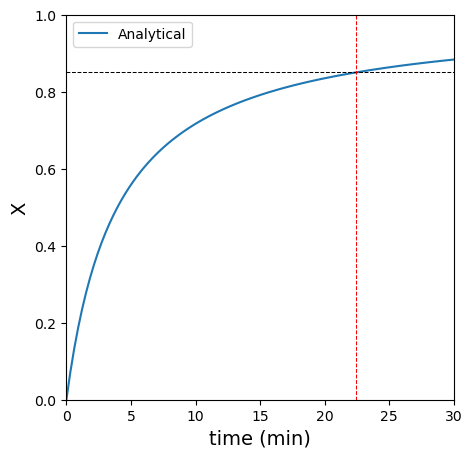

In [124]:
##############################################################################################
# Graph x(t); illustrate (t, x) location where x = 0.85; this is the solution to the problem #
############################################################################################## 

tplot = np.linspace(0,30,100)
xplot = x(tplot)
plt.figure(1, figsize = (5, 5))
plt.plot(tplot, xplot, label = 'Analytical')
plt.hlines(0.85, tplot[0], tplot[-1], linestyle = 'dashed', color = 'black', linewidth = 0.75)
plt.vlines(22.397891963109352, 0, 1, linestyle = 'dashed', color = 'red', linewidth = 0.75)
plt.xlabel('time (min)', fontsize = 14)
plt.ylabel('X', fontsize = 14)
plt.xlim(0,30)
plt.ylim(0,1)
plt.legend(loc = 'upper left')
plt.show()

From the graph, we can see that somewhere around $t = 23$ minutes, $x \approx 0.85$.  We can do better than that though.  In many ways.

### Analytical Solution

First, we recall that this is a separable ODE with a relatively clean analytical solution. We actually can solve directly for for $t$ as an explicit function of $x$:

$$t(x) = \frac{1}{k}\left(\frac{1}{1 - x} - 1\right)$$

With that function in hand, we only need to plug in a value of $x = 0.85$; it will return the exact time required to reach this value of x.

In [125]:
#####################################################################################
# Obtain the exact time required for x = 0.85 from the analytical solution          #
#####################################################################################

t = lambda x: 1/k*(1/(1 - x) - 1)
print(f'To achieve a conversion of 85%, it will take t = {t(0.85):11.8f} minutes')

To achieve a conversion of 85%, it will take t = 22.39789196 minutes


### Using `scipy.optimize()` to find the requested information from the analytical solution(s)

In some cases, we might find that $x(t)$ is a highly nonlinear function and that it is difficult or maybe impossible to solve for $t$ as an explicit function of $x$. That ***isn't*** the case for this problem, but we should recognize that it is a possibility and know what to do in these cases. One thing we can do is leverage the fact that we do have an analytical solution for $x(t)$, specifically:

$$x(t) = 1 - \frac{1}{1+kt}$$

We can use that to make a univariate objective function wherein $t$ is our only unknown, and we are searching for the value of $t$ where $x = 0.85$. Specifically:

$$\mathrm{obj}(t) = x(t) - 0.85$$

As we discussed in [Notebook 03](https://jqbond.github.io/CEN587/Notebooks/587-N03.html), this type of problem can be solved using a univariate solver like `opt.newton()`. This is an extremely useful technique when we have an analytical solution for one variable as a function of the other, e.g., $x(t)$ but we cannot easily rearrange that function to obtain $t(x)$. 

In [126]:
#########################################################################################
# solve x(t) = 0.85 numerically using opt.newton()                                      #
#########################################################################################

obj = lambda t: x(t) - 0.85
ans_newton, info = opt.newton(obj, 20, full_output = True)
print(f'The solution using opt.root() is t = {ans_newton:17.14f} minutes, and the analytical solution is {t(0.85):17.14f} minutes')

The solution using opt.root() is t = 22.39789196310934 minutes, and the analytical solution is 22.39789196310935 minutes


### More general and complex examples

More commonly in reactor design, we'll have to work with ODEs or systems of ODES that we cannot solve by hand. In these cases, we will be committed to using the ODE solvers in `solve_ivp()`. The above strategies rely on having an analytical solution for the state dependent variable, and they won't be options when we have to use `solve_ivp()`.  In these cases, we'll have to use numerical methods, and again, we have a few options. For example, here, we might recognize that finding the time where $x = 0.85$ involves solving the differential equation below:

$$\frac{1}{(1-x)^2}dx = kdt$$

For limits of $x = (0.0, 0.85)$ and limits on t of $(0, t)$. Here, the upper limit is what we want to solve for, and we've recast the problem as a definite integral:

$$\int_0^{0.85}\frac{1}{k(1-x)^2}dx = \int_0^tdt = t$$

Rearranging, we now have an explicit solution for $t$ at $x = 0.85$. We can find the numerical value of $t$ where $x = 0.85$ by solving the integral below:

$$t = \int_0^{0.85}\frac{1}{k(1-x)^2}dx$$

We know that we can solve this particular integral by hand, but that will not always be possible. This is a very common problem in reactor design, and it is a good application for Gaussian Quadrature, which gives us a very accurate way to solve definite integrals when there is no straightforward analytical solution:

In [127]:
##########################################################################
# Solve the above definite integral to find t where x = 0.85             #
##########################################################################

integrand = lambda x: 1/k/(1 - x)**2
integral, err = quad(integrand, 0, 0.85)
print(f'The solution using quad() is t = {integral:18.15f} minutes, and the analytical solution is {t(0.85):18.15f} minutes')

The solution using quad() is t = 22.397891963109348 minutes, and the analytical solution is 22.397891963109352 minutes


### Solving by interpolation with `scipy.interp1d()`

Unfortunately, sometimes it isn't possible for us to formulate design problems as a single, definite integral (which is necessary for Gaussian Quadrature). We usually are only able to reduce a problem to a single definite integral when we have (1) simple reactors and (2) simple reactions. In cases where we have to analyze complex systems involving multiple species and multiple reactions, it is much more straightfoward to step-based solves like those in `solve_ivp()`. Although they are relatively easy to implement once you get the hang of the syntax, they can be a little trickier in these types of problems where we are looking for the value of the independent variable ($t$ here) that gets you a certain value of dependent variable ($x$ here). The crux of problem is that with an iterative, step-based solver like `solve_ivp()`, we must supply it with an integration span at the outset, which means we have to specify where it starts integration and where it ends integration. The problem is that we have no way of knowing a priori if the state variables will reach their target values within that integration span. A second issue is that, even if the state variables reach their target within the integration span, there is no way for us to say where within the integration span the state variable will hit its target value. This usually means that we are going to have to guess an integration span, solve the ODE, determine whether the state variable reached its target, change the integration span as needed until the state variable reaches its target, and then determine where precisely within the integration span the state variable reached its target. There are some elegant ways to handle this type of scenario, but we won't use them in this course because they are somewhat difficult to understand if you don't already have mastery of the algorithms in Python. It is better here that we use a less elegant but easier to understand and arguably more educational approach to solving these problems.

Below, we re-solve our ODE using `solve_ivp()` (Runge Kutta method), except we want to make sure that our x-value reaches 0.85. So we pick a span of $t$ values that we think is large enough to go past this value. Let's set aside that we actually know that $x = 0.85$ at $t =\approx 22.4 \ \mathrm{minutes}$ and approach the problem as we might in reactor design, where we have no idea where the solution occurs. We'll start by guessing that an appropriate integration span is $t = (0, 15)$. 

Let's solve the problem on that time domain and see what we get.  We specifically want to determine whether our state dependent variable, $x$ has reached a value of $0.85$ within this time span. We can do so by (1) displaying the set of state variables and (2) graphing the solution.

In [128]:
#####################################################################
# Solving the ODE for t = (0, 15)                                   #
#####################################################################

tspan = (0.0, 15.0)
x0    = [0.0]
ans2  = solve_ivp(DX, tspan, x0)
ans2

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  1.000e-04  1.100e-03  1.110e-02  1.111e-01
             1.111e+00  2.978e+00  5.845e+00  1.035e+01  1.500e+01]
        y: [[ 0.000e+00  2.530e-05  2.782e-04  2.800e-03  2.734e-02
              2.194e-01  4.296e-01  5.963e-01  7.234e-01  7.912e-01]]
      sol: None
 t_events: None
 y_events: None
     nfev: 56
     njev: 0
      nlu: 0

When we display the solution structure, we see that our state variable $x$ ranged from 0 to approximately 0.79 on this domain. This suggests that we did not cross $x = 0.85$, though it can be hard to tell in cases where a state variable may not be monotonic (increasing or decreasing continuously). It is therefore helpful to graph the result. We'll overlay the result with our analytical solution and see how we did; we'll zoom in on the targeted values of x to try to see where the solution is.

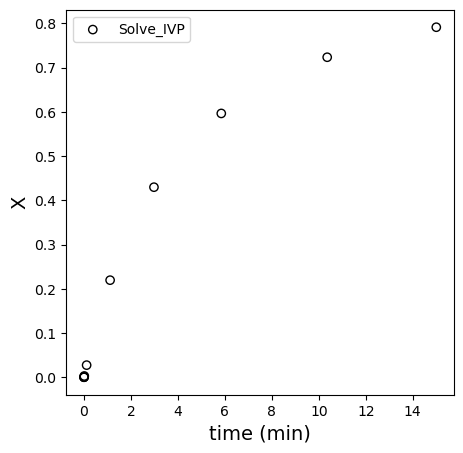

In [129]:
tout2 = ans2.t
xout2 = ans2.y
plt.figure(1, figsize = (5, 5))
plt.scatter(tout2, xout2, c = 'None', edgecolor = 'black', label = "Solve_IVP")
plt.xlabel('time (min)', fontsize = 14)
plt.ylabel('X', fontsize = 14)
plt.legend(loc = 'upper left')
plt.show()

That illustration makes it very clear that, after $t = 15 \ \mathrm{minutes}$, $x$ has not yet reached a value of $0.85$. We can see, though, that $x$ is increasing monotonically as a function of time. This suggests that if we extend the integration span to a long time, we should be able to find the value of $t$ where $x = 0.85$.  Below, we will re-integrate the ODE using a span of $t = (0, 30)$. We will then display the state variable $x$ and graph its behavior as a function of $t$.  In this case, we'll overlay the analytical solution to provide contrast between a function (continuous) and the solution to an ODE/IVP obtained using a step-based solver (dicrete).

[[0.00000000e+00 2.52993599e-05 2.78222571e-04 2.80043554e-03
  2.73398240e-02 2.19418001e-01 4.29606264e-01 5.96345844e-01
  7.23381599e-01 8.15569975e-01 8.80254824e-01 8.83043281e-01]]


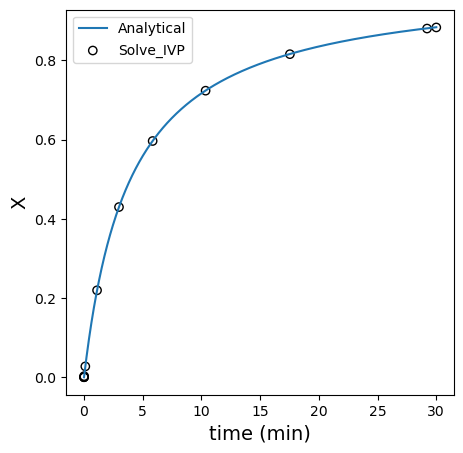

In [130]:
#####################################################################
# Solving the ODE for t = (0, 15)                                   #
#####################################################################

tspan = (0.0, 30.0)
x0    = [0.0]
ans2  = solve_ivp(DX, tspan, x0)
print(ans2.y)

tout2 = ans2.t
xout2 = ans2.y
tplot = np.linspace(0,30,1000)
xplot = x(tplot)
plt.figure(1, figsize = (5, 5))
plt.plot(tplot, xplot, label = 'Analytical')
plt.scatter(tout2, xout2, c = 'None', edgecolor = 'black', label = "Solve_IVP")
plt.xlabel('time (min)', fontsize = 14)
plt.ylabel('X', fontsize = 14)
# plt.xlim(15,30)
# plt.ylim(0.8,0.9)
# plt.yticks(np.arange(0.8, 0.91, 0.025, dtype = float))
plt.legend(loc = 'upper left')
plt.show()

Now we need to figure out where in $t$ we would find $x = 0.85$. Keep in mind that we need to do this using our `solve_ivp()` solution, which is ***not a continuous function***. Rather, it is ***a discrete set of $(t, x)$ pairs***. Below, we zoom in on the area near the solution, and you can see that our ode solver actually stepped right over the solution at $t \approx 22.4$! The consequence is that we did not actually find the time where $x = 0.85$ with our ODE solver in `solve_ivp()`. Instead, we found times where $x < 0.85$ and times where $x > 0.85$. We also have a general sense of the shape of $x(t)$ even if we cannot obtain the exact analytical solution for $x(t)$ from our `solve_ivp()` solution. This is a very common issue with step-based solver algorithms, and we encounter it all the time in reactor design. There are a few ways to find the correct time of interest. Generally, they require us to interpolate values of $x$ at time points where the solver did not step. There are additional tools in Python that help us to do this.

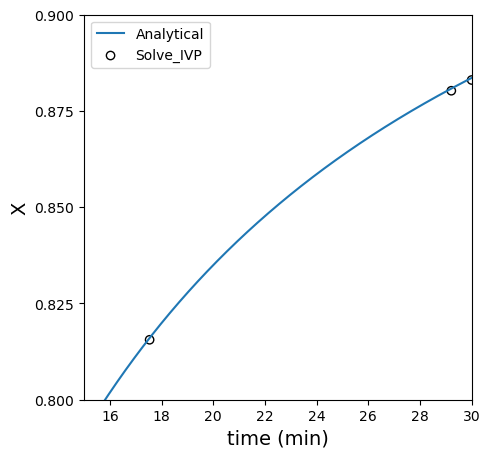

In [131]:
#####################################################################
# Zoom in on area near solution to highlight consequence of steps   #
#####################################################################

tout2 = ans2.t
xout2 = ans2.y
tplot = np.linspace(0,30,1000)
xplot = x(tplot)
plt.figure(1, figsize = (5, 5))
plt.plot(tplot, xplot, label = 'Analytical')
plt.scatter(tout2, xout2, c = 'None', edgecolor = 'black', label = "Solve_IVP")
plt.xlabel('time (min)', fontsize = 14)
plt.ylabel('X', fontsize = 14)
plt.xlim(15,30)
plt.ylim(0.8,0.9)
plt.yticks(np.arange(0.8, 0.91, 0.025, dtype = float))
plt.legend(loc = 'upper left')
plt.show()

### Finding the solution by interpolation

Here, that issue of not knowing exactly where to "step" with the independent variable comes into play.  We see that the solver basically jumped right over the desired value of $x = 0.85$.  We can estimate the value of $t$ where $x = 0.85$ using interpolation.  This can be accomplished using `interp1d()` from the `scipy.interpolate` package. `interp1d()` has the following basic syntax:

    interp1d("values of independent variable", "corresponding value of dependent variables", kind = 'type of interpolation')

As an output, `interp1d()` returns an interpolating polynomial. Once we have this interpolating polynomial, we can use it to return the value of the dependent variable at any new independent variable value that is within the limits of the independent variable values that you initially passed to the `interp1d()` constructor.  One important note is that the array of independent variables and the array of dependent variables need to have the same dimensions. This is illutrated in the code cell below.

```{tip}
The "independent variable" and "dependent variable" that we pass to `interp1d()` are whatever we choose them to be.  If it is of interest for us to know $t(x)$, for example, and we have a discrete set of $(t, x)$ data available, then we would pass $x$ as the independent variable and $t$ as the dependent variable. This would generate an interpolating polynomial that tells us the approximate behavior of $x(t)$
```

In [132]:
#####################################################################
# Create an  interpolating polynomial approximation for t(x)        #
#####################################################################

tout2  = ans2.t
xout2a = ans2.y
xout2b = ans2.y[0]

print(tout2.shape)
print(xout2a.shape)
print(xout2b.shape, '\n')

##########################################################################
# The line below creates the interpolating polynomial from discrete data #
##########################################################################

int1 = interp1d(xout2b, tout2, kind = 'linear')

##########################################################################
# Displaying results for t(0.85)                                         #
##########################################################################

int1(0.85)
print(f't = {int1(0.85):7.4f} minutes by interpolation of solve_ivp(), and the analytical solution is t = {t(0.85):7.4f} minutes')

(12,)
(1, 12)
(12,) 

t = 23.7503 minutes by interpolation of solve_ivp(), and the analytical solution is t = 22.3979 minutes


We see that it has some inaccuracy compared to our analytical solution!  This is because we are using a straight line to predict the value of a point in between two points on a curved line. We can visualize this by overlaying the interpolating polynomial approximation for $x(t)$ with the actual solution for $x(t)$

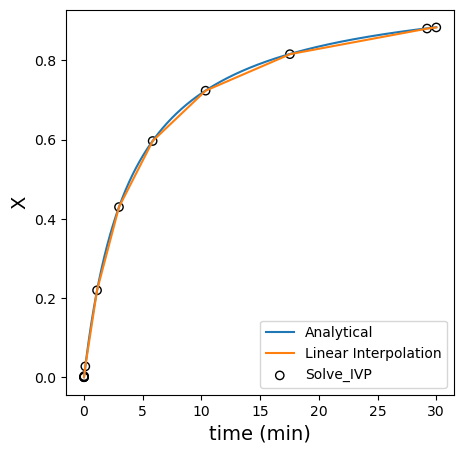

In [133]:
#########################################################################################
# Create an interpolating polynomial approximation for x(t) from discrete data          #
#########################################################################################

int2 = interp1d(tout2, xout2b, kind = 'linear')

#########################################################################################
# Overlay ODE solution, interpolating polynomial approximation, and analytical solution #
#########################################################################################

plt.figure(1, figsize = (5, 5))
plt.plot(tplot, xplot, label = 'Analytical')
plt.plot(tplot, int2(tplot), label = 'Linear Interpolation')
plt.scatter(tout2, xout2, c = 'None', edgecolor = 'black', label = "Solve_IVP")
plt.xlabel('time (min)', fontsize = 14)
plt.ylabel('X', fontsize = 14)
# plt.xlim(15,30)
# plt.ylim(0.8,0.9)
plt.legend(loc = 'lower right')
plt.show()

### Cubic spline interpolation

For nonlinear functions, like $x(t)$, we can improve accuracy some by using a cubic spline:

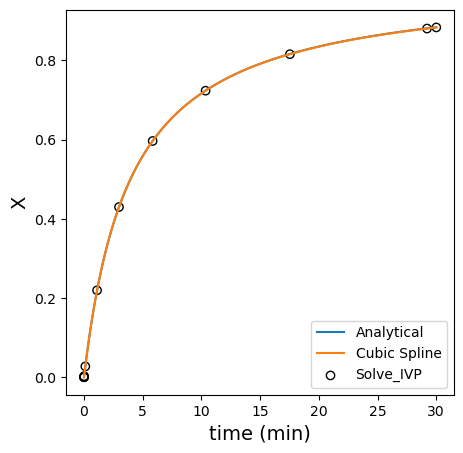

In [134]:
#########################################################################################
# Create an cubic spline polynomial approximation for x(t) from discrete data           #
#########################################################################################

int2 = interp1d(tout2, xout2b, kind = 'cubic')

#########################################################################################
# Overlay ODE solution, interpolating polynomial approximation, and analytical solution #
#########################################################################################

plt.figure(1, figsize = (5, 5))
plt.plot(tplot, xplot, label = 'Analytical')
plt.plot(tplot, int2(tplot), label = 'Cubic Spline')
plt.scatter(tout2, xout2, c = 'None', edgecolor = 'black', label = "Solve_IVP")
plt.xlabel('time (min)', fontsize = 14)
plt.ylabel('X', fontsize = 14)
# plt.xlim(15,30)
# plt.ylim(0.8,0.9)
plt.legend(loc = 'lower right')
plt.show()

In [135]:
################################################################################
# Create an interpolating polynomial approximation for t(x) using cubic spline #
################################################################################

int1 = interp1d(xout2b, tout2, kind = 'cubic')
print(f't = {int1(0.85):7.4f} minutes by interpolation of solve_ivp(), and the analytical solution is t = {t(0.85):7.4f} minutes')

t = 22.4355 minutes by interpolation of solve_ivp(), and the analytical solution is t = 22.3979 minutes


This does a better job, but it is still a rough approximation to the true solution. The reason is that the two points we are looking at are actually a bit far away from $x = 0.85$.

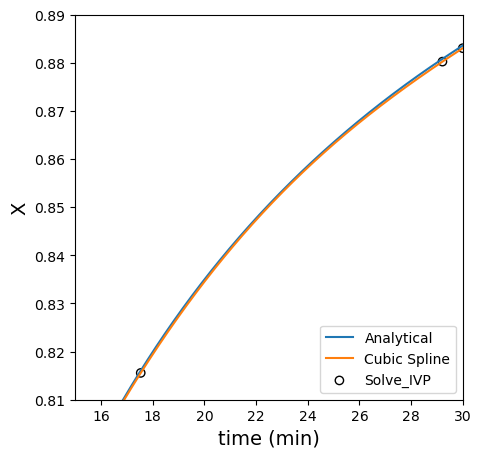

In [136]:
################################################################################
# Zoom in on region near solution to show that x(t) != itp2(t)                 #
################################################################################

plt.figure(1, figsize = (5, 5))
plt.plot(tplot, xplot, label = 'Analytical')
plt.plot(tplot, int2(tplot), label = 'Cubic Spline')
plt.scatter(tout2, xout2, c = 'None', edgecolor = 'black', label = "Solve_IVP")
plt.xlabel('time (min)', fontsize = 14)
plt.ylabel('X', fontsize = 14)
plt.xlim(15,30)
plt.ylim(0.81,0.89)
plt.legend(loc = 'lower right')
plt.show()

### Integration Tolerances

We can improve the precision of the integration, which increases the number of points available for interpolation and allows us to use points closer to the true value.

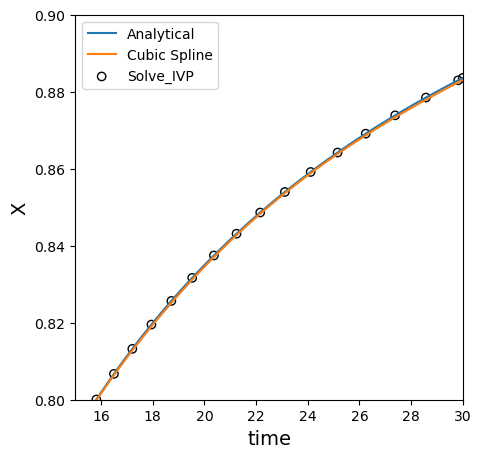

t = 22.397890 minutes by interpolation of solve_ivp(), and the analytical solution is t = 22.397892 minutes


In [137]:
################################################################################
# Reintegrate using solve_ivp() with tighter precision tolerances              #
################################################################################

tspan = (0.0, 30.0)
x0    = [0.0]
ans3  = solve_ivp(DX, tspan, x0, atol = 1e-10, rtol = 1e-10)
tout3 = ans3.t
xout3 = ans3.y[0]
tplot = np.linspace(0,30,1000)
xplot = x(tplot)

################################################################################
# Construct polynomial approximation for x(t) using cubic spline               #
################################################################################

int2  = interp1d(tout2, xout2b, kind = 'cubic')

################################################################################
# Overlay analytical solution, solve_ivp() solution, and spline approximation  #
################################################################################

plt.figure(1, figsize = (5, 5))
plt.plot(tplot, xplot, label = 'Analytical')
plt.plot(tplot, int2(tplot), label = 'Cubic Spline')
plt.scatter(tout3, xout3, c = 'None', edgecolor = 'black', label = "Solve_IVP")
plt.xlabel('time', fontsize = 14)
plt.ylabel('X', fontsize = 14)
plt.xlim(15,30)
plt.ylim(0.8,0.9)
plt.legend(loc = 'upper left')
plt.show()

################################################################################
# Construct polynomial approximation for t(x) using cubic spline               #
################################################################################

int1 = interp1d(xout3, tout3, kind = 'cubic')
print(f't = {int1(0.85):9.6f} minutes by interpolation of solve_ivp(), and the analytical solution is t = {t(0.85):9.6f} minutes')

### Combining `solve_ivp()` with `scipy.optimize()`

An alternate strategy is given below. We should recognize that, broadly in science, engineering, and mathematics, it is very common that one might need to evaluate differential equation solutions at points other than those chosen by the solver. Although we should not attempt to modify the steps taken by ODE solver algorithms, we ***can*** use other features of ODE solvers in Python to make our lives easier. Of specific interest here is that Python is capable of returning interpolation polynomials that describe the behavior of state variables as a function of the independent variable. It basically automates what we did above and returns the result as part of the ODE solution structure. This is not a default option with `solve_ivp()`, and we need to enable it using the `dense_output` keyword argument. In the next few code cells, we'll look at how to use this interpolating polynomial; it is really useful!!

The interpolating polynomial produced by enabling `dense_output` is located in the `.sol` field of the solution structure. In the cell below, we use it to find the value of x at a time of 20 minutes.

```{tip}
The interpolating polynomial returned by enabling `dense_output` will return an array containing values of all state variables at all values of the independent variable passed to the polynomial. Extracting a specific value requires us to use appropriate indices that correspond to the specific element in the array that is of interest.
```

In [138]:
#################################################################################
# Solve ODE problem using solve_ivp() with dense output enabled                 #
#################################################################################

ans4 = solve_ivp(DX, tspan, x0, dense_output = True, rtol = 1e-10, atol = 1e-10)
print(ans4, '\n')
print(ans4.sol, '\n')
print(ans4.sol(20), '\n')
print(ans4.sol(20)[0])



  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  1.000e-04 ...  2.982e+01  3.000e+01]
        y: [[ 0.000e+00  2.530e-05 ...  8.830e-01  8.836e-01]]
      sol: <scipy.integrate._ivp.common.OdeSolution object at 0x0000023419C343C0>
 t_events: None
 y_events: None
     nfev: 464
     njev: 0
      nlu: 0 


[0.8349835] 

0.8349834983313625


### Use the dense output to create an objective function

One of my favorite ways to use the dense output is to create an objective function that we can solve to find where $x = 0.85$. Basically, we use `opt.newton()` to iteratively pass values of $t$ into the interpolating polynomial until we find the root, i.e., the location where $x = 0.85$.

In [139]:
####################################################################################################################################
# This cell uses the dense_output interpolating polynomial to build a univariate objective function and solve it with opt.newton() #
####################################################################################################################################

obj = lambda t: ans4.sol(t)[0] - 0.85
ans5, info = opt.newton(obj, 20, full_output = True)
print(f'{ans5:0.4f}, {t(0.85):0.4f}')

22.3979, 22.3979


## Problem 2

Solve the following system of ODEs; plot $x$ and $y$ on the domain $t = [0, 5]$.

\begin{align}
\frac{dx}{dt} &= -x + y\\
\frac{dy}{dt} &=  x - y - 0.1y^2\\
x(0) &= 10\\
y(0) &= 20
\end{align}



### Solution to Problem 02

If you follow the approach above, and if you understood the difference between solving univariate equations with `opt.newton()` compared to solving systems of equations with `opt.root()`, this transition will be similar. The key is that we have to recognize that the function we build here to pass to `solve_ivp()` always has the basic structure:

$$f(\text{independent variable, state dependent variable})$$

In other words, `solve_ivp()` will only work directly on two arguments. In this case, we have an independent variable ($t$), and we have two state dependent variables $(x,y)$. As with `opt.root()`, we have to stack these dependent variables inside of a list or array. The function that we define also must return the derivative of each state variable as an output. Once we construct the function, we follow a similar strategy to the one used above for solving a single ODE. Specifically,along with the ODE function, we pass initial values of each state variable in an array, and we pass an integration span as an array or tuple. 

As we work through this problem, we should also be sure to check the solution structure outputs so that you understand that values of the independent and dependent variables are stored as arrays inside of the `.t` and `.y` fields of the solution structure. It is generally important for us to understand the shapes of these arrays and the information that they contain.

`.t` will contain all values of the independent variable that the solver algorithm stepped to. It will be a 1D array, and it will have a number of elements that corresponds to the number of steps taken by the solver. As such:

`.t.shape = (# steps, )`

`.y` will contain all values of all state variables at each step taken by teh solver. It will be a 2D array, and it will have the following shape:

`.y.shape = (# state variables, # steps)`

In [140]:
###############################################################################################################
# This cell builds the ODE system as a function                                                               #
# Notice that it takes a scalar independent variable, t, and an array state dependent variable, var           #
# Notice that it returns the derivatives of x, dx/dt, and y, dy/dt, in an array of the same size/shape as var #
###############################################################################################################

def P2(t, var):
    x = var[0]
    y = var[1]
    dxdt = -x + y
    dydt =  x - y - 0.1*y**2
    return np.array([dxdt, dydt])
  
tspan = (0, 5)
var0  = [10, 20]
P2sol = solve_ivp(P2, tspan, var0, rtol = 1e-6, atol = 1e-6)
P2sol

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  1.600e-02 ...  4.831e+00  5.000e+00]
        y: [[ 1.000e+01  1.015e+01 ...  4.186e+00  4.069e+00]
            [ 2.000e+01  1.923e+01 ...  3.474e+00  3.392e+00]]
      sol: None
 t_events: None
 y_events: None
     nfev: 170
     njev: 0
      nlu: 0

### The Solution Structure for ODE systems

Note again the shape of the independent variable in the solution structure (`.t` field) is a 1D structure, while the shape of the dependent variable (`.y` field) is a 2D array.  We have to take this into account when trying to use the information e.g., when plotting.


In [141]:
##########################################################################################################################
# This cell displays the size/shape of elements in the solution structure that contain the  "answers" to the ODE problem #
##########################################################################################################################

print(P2sol.t.shape, '\n')
print(P2sol.y.shape, '\n')
P2tout = P2sol.t
P2xout = P2sol.y[0] #This is equivalent to P2sol.y[0, :], i.e., "first row, all columns". It stores the result as a 1D array of the same size/shape as P2sol.t
P2yout = P2sol.y[1] #This is equivalent to P2sol.y[1, :], i.e., "first row, all columns". It stores the result as a 1D array of the same size/shape as P2sol.t
print(P2xout.shape, P2yout.shape, '\n')
print(P2xout, '\n')
print(P2yout, '\n')

(28,) 

(2, 28) 

(28,) (28,) 

[10.         10.15256289 10.59164198 10.90355112 11.11840061 11.23763618
 11.26705888 11.21418751 11.08768196 10.8966901  10.65030235 10.35709832
 10.02483566  9.66025165  9.26893873  8.85524     8.42208297  7.97058303
  7.49892862  6.99850385  6.43079004  5.93920905  5.5085689   5.12777362
  4.78497023  4.47254698  4.18623952  4.06885595] 

[20.         19.23190276 16.92295808 15.08222354 13.51864663 12.20579981
 11.10781282 10.191839    9.42753049  8.78763558  8.24802396  7.7876295
  7.38834074  7.03478211  6.71402164  6.41521841  6.12919366  5.84784313
  5.56309687  5.26414736  4.92263603  4.62121196  4.35094133  4.10618608
  3.88068339  3.67055279  3.47387665  3.39205468] 



### Visualizing the Solution to the ODE System

And we can plot for visualization. 

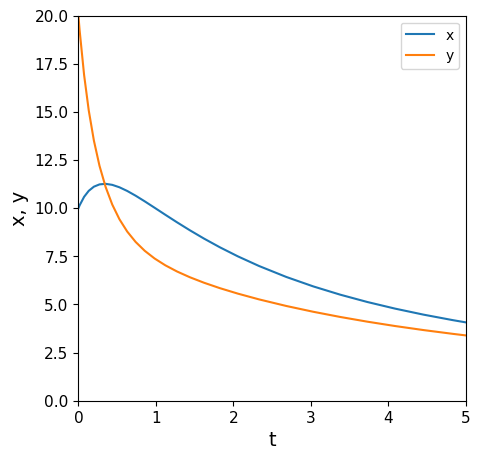

In [142]:
##################################################################################
# This cell graphs results for x(t) and y(t)                                     #
##################################################################################

plt.figure(1, figsize = (5, 5))
plt.plot(P2tout, P2xout, label = 'x')
plt.plot(P2tout, P2yout, label = 'y')
plt.xlabel('t', fontsize = 14)
plt.ylabel('x, y', fontsize = 14)
plt.xticks(fontsize = 11)
plt.yticks(fontsize = 11)
plt.xlim(0, 5)
plt.ylim(0, 20)
plt.legend()
plt.show()